# Stock market forecasting using XGBoost linear model

- The goal is to build and train a forecasting model using five years of stock market data. We will then use the trained model to predict out five days into the future using live data. 


- The dataset that is being used is obtained from kaggle. This dataset has all the SP500 companies aggregated into one csv file which we will use train on.


- It is important to notice that this is a forecasting model instead of predicting model. Predicting the stock market is quite difficult which require usually a lot more data. 


- Predictive strategies are usually less than 60% accurate, but its enough for hedge funds to capitalise on them using leverage. 

In [1]:
#import all the neccessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib
import datetime, random
import numpy as np; np.random.seed(0)
import warnings
import itertools
import numpy as np
import pandas_datareader.data as web
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')


In [2]:
#load the csv file
stocks_df=pd.read_csv('all_stocks_5yr.csv')
stocks_df

,date,open,high,low,close,volume,Name
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM
...,...,...,...,...,...,...,...
606796,2017-08-07,62.12,62.34,61.25,61.83,4208287.0,ZTS
606797,2017-08-08,60.49,61.00,59.50,60.00,4663668.0,ZTS
606798,2017-08-09,59.95,60.87,59.76,60.81,4017297.0,ZTS
606799,2017-08-10,60.87,61.37,59.71,59.74,2690725.0,ZTS


In [3]:
#check the date ranges
print(str('Earliest date: '+np.min(stocks_df['date'])))
print(str('Latest date: '+np.max(stocks_df['date'])))

Earliest date: 2012-08-13
Latest date: 2017-08-11


In [4]:
#Check how many symbols we have
print(str('Total symbols: '+str(len(set(stocks_df['Name'])))))

Total symbols: 503


In [5]:
stocks_df.describe()

,open,high,low,close,volume
count,606417.000000,606593.000000,606574.000000,606801.000000,6.063950e+05
mean,79.529041,80.257435,78.799338,79.557920,4.500925e+06
std,93.383162,94.187977,92.535300,93.382168,9.336171e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,38.070000,38.460000,37.700000,38.090000,1.077091e+06
50%,59.240000,59.790000,58.690000,59.270000,2.131913e+06
75%,89.390000,90.150000,88.620000,89.430000,4.442768e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


- It is always good to see how the data looks beforehand just to check if there are any anomalies  we should look into. We can see that min stock value is 1.62 whereas the max is 2044. Looking at this we may have to normalise the data when training

In [6]:
stocks_df.shape

(606801, 7)

No handles with labels found to put in legend.


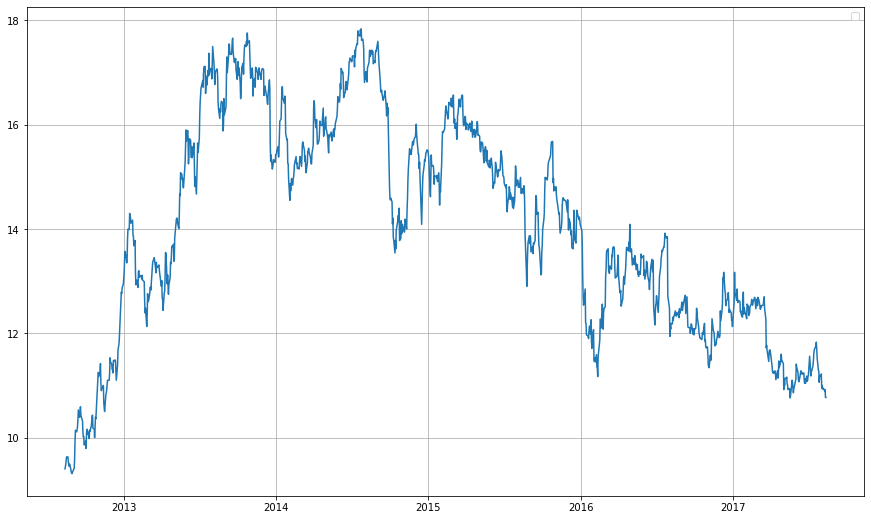

In [7]:
# Quick visualisation 

#plot Ford stock by itself
temp_df=stocks_df[stocks_df['Name']=='F']
#set index to date
temp_df=temp_df.set_index(temp_df['date'])


plt.subplots(figsize=(15,9))
#dont forget to set date to datetime for better quality plotting
plt.plot(pd.to_datetime(temp_df['date']),temp_df['close'])
plt.grid()
plt.legend(loc='best')


No handles with labels found to put in legend.


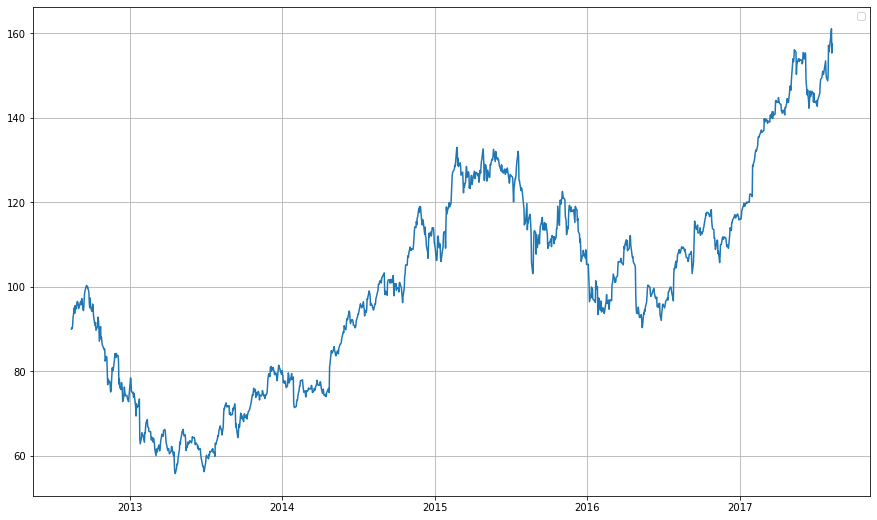

In [8]:
#plot Ford stock by itself
temp_df2=stocks_df[stocks_df['Name']=='AAPL']
#set index to date
temp_df2=temp_df2.set_index(temp_df['date'])


plt.subplots(figsize=(15,9))
#dont forget to set date to datetime for better quality plotting
plt.plot(pd.to_datetime(temp_df2['date']),temp_df2['close'])
plt.grid()
plt.legend(loc='best')

# The Plan

- It is imperative that we take the consecutive data as this is a time series data hence the order at which the price moves is of high importance.


- The main theory behind this forecasting model is the assumption that markets are always in a trend. If today is an up day then tomorrow is more likely to be an upday and vice versa. 


- As mentioned before the goal is to forecast individual stocks five days in the future. We will do this by taking 10 consecutive trading days of a given stock and forecast 5 days out.


- We will give the model 10 days of trading data to analyse the trend in the data and forecast out accordingly.


# Normalizing 

- In order to present the relationship between the data points more accurately, we will normalize the data. Normalizing will help the model learn better as large stock values will not skew the data when forecasting.  


- We will use log transform for this case as its simple to use, we could also use Min Max scalar from sklearn to normalize the data also.


- The log transform mainly clumps the data points closer together (by putting them on a log scale) so that there aren't any big variation in the dataset which may confuse the model.



In [9]:
#get stock data
stock_data=stocks_df[stocks_df['Name']=='KSU']

d=np.log(stock_data[['close']])
d.head()

,close
322632,4.303930
322633,4.322542
322634,4.333624
322635,4.338597
322636,4.353756


# Getting the data ready for the model

## Feature engineering

- We will be separating out the data into features and labels or x and y. 


- What we will be doing is taking the first 10 consecutive price values and saving them into x list, we will then take the following five consecutive values and save them into y list. We will keep iterating down by one increment until we get to end of dataset.  We will do this for each stock symbol.




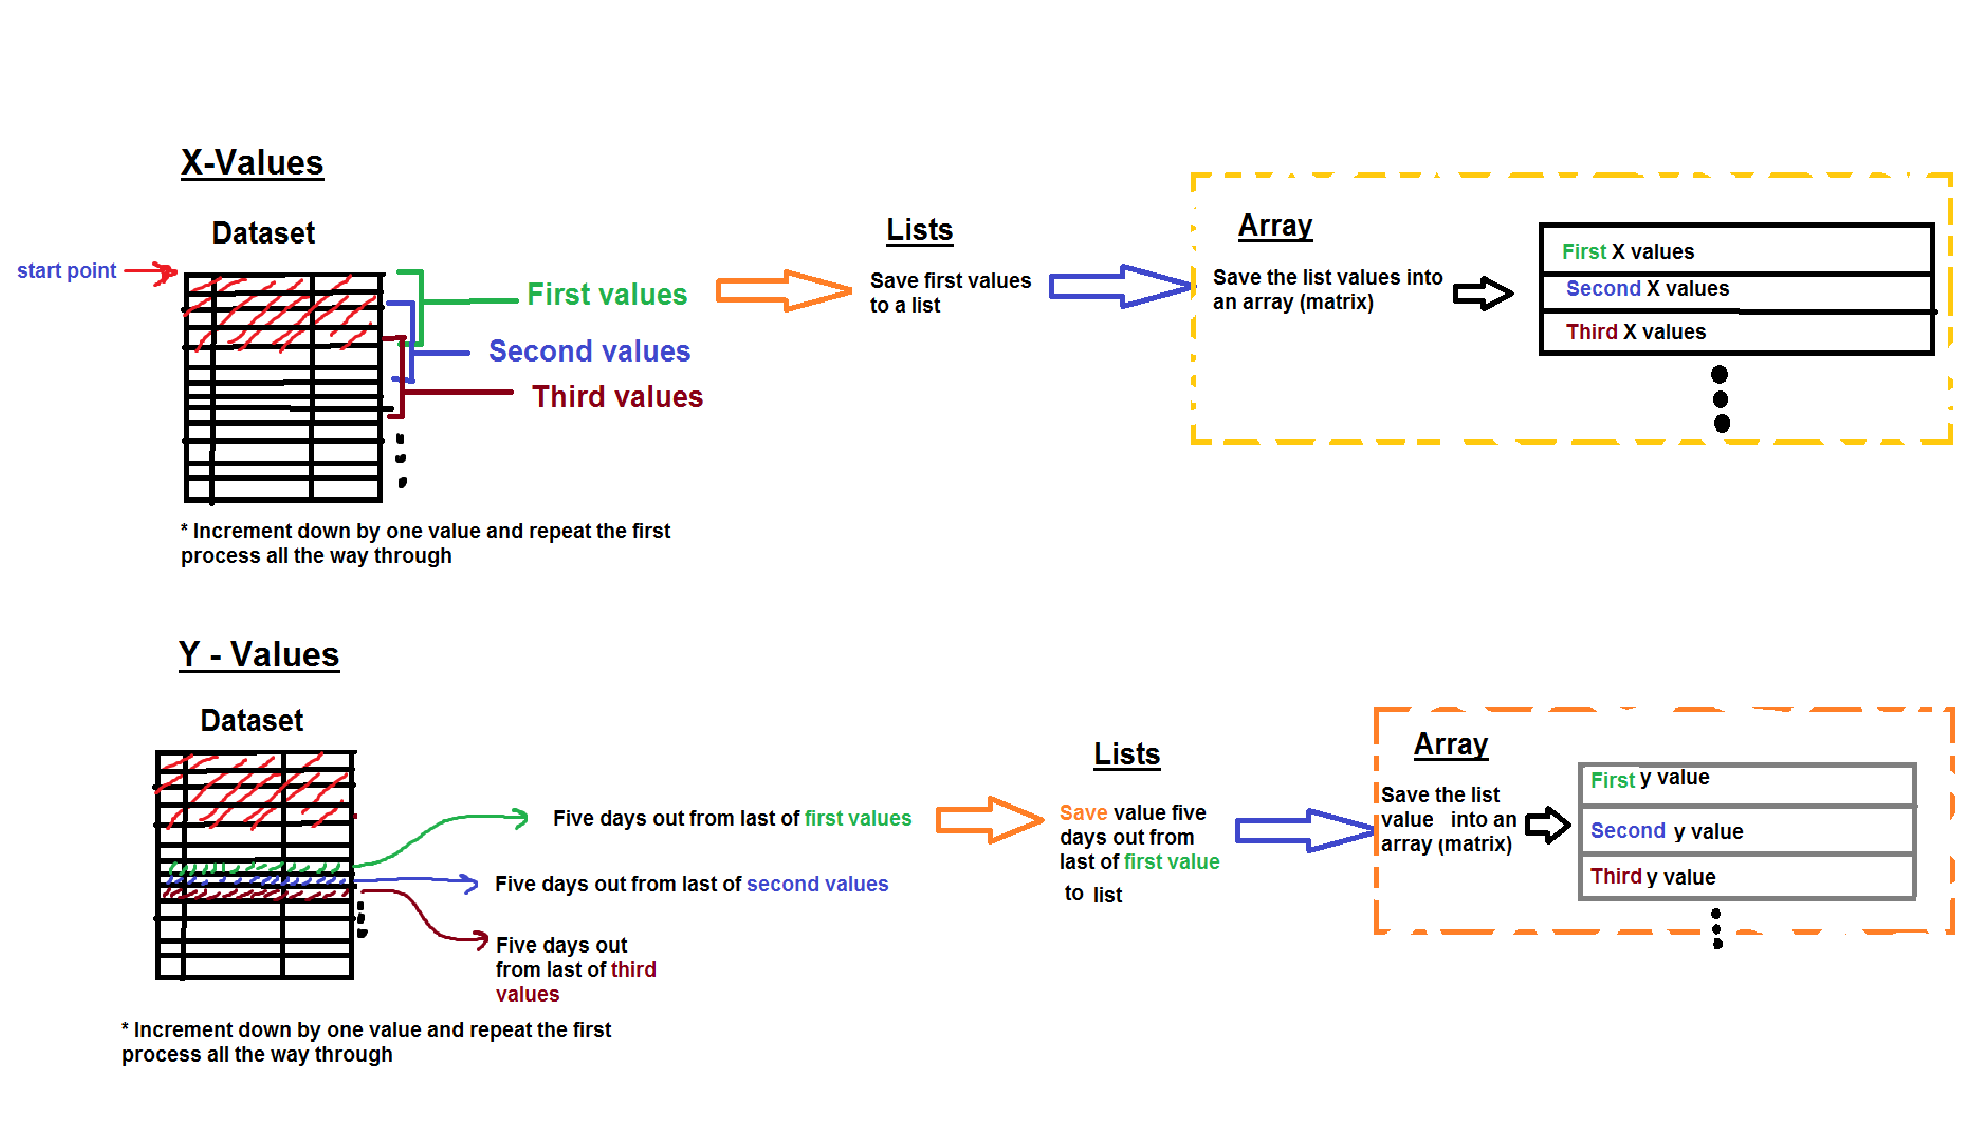

In [10]:
from IPython.display import Image
Image(filename='Process.png')

In [11]:
#Have all the stock symbols ready
stock_symbols = list(set(stocks_df['Name']))
stock_symbols

['ES',
 'YUM',
 'MGM',
 'AVGO',
 'CTSH',
 'ADP',
 'ETN',
 'ECL',
 'CNC',
 'BEN',
 'PRU',
 'TSS',
 'MO',
 'VZ',
 'TAP',
 'F',
 'CA',
 'ESRX',
 'DHI',
 'CMCSA',
 'HRS',
 'SO',
 'MTB',
 'WBA',
 'SIG',
 'UTX',
 'DVA',
 'RL',
 'APD',
 'KSS',
 'BAC',
 'PPL',
 'DIS',
 'PBCT',
 'TRIP',
 'GT',
 'SYY',
 'BF.B',
 'NLSN',
 'HIG',
 'D',
 'ABT',
 'GE',
 'KHC',
 'AIV',
 'MS',
 'BXP',
 'SNI',
 'ADS',
 'ADI',
 'BHGE',
 'CF',
 'FISV',
 'URI',
 'ABBV',
 'AMP',
 'CTXS',
 'MCO',
 'UHS',
 'BWA',
 'KLAC',
 'DVN',
 'LYB',
 'FFIV',
 'EXPD',
 'ULTA',
 'CELG',
 'MCK',
 'NAVI',
 'LLL',
 'OMC',
 'SLB',
 'BCR',
 'VFC',
 'WYN',
 'ADSK',
 'BMY',
 'CCL',
 'KORS',
 'PHM',
 'MMC',
 'VRTX',
 'EL',
 'DG',
 'MRK',
 'BBY',
 'SYMC',
 'XL',
 'FBHS',
 'EVHC',
 'COL',
 'GWW',
 'XYL',
 'PCLN',
 'CL',
 'AOS',
 'DLPH',
 'KMB',
 'DRE',
 'PDCO',
 'DGX',
 'FLS',
 'CXO',
 'CERN',
 'FTV',
 'COST',
 'GRMN',
 'MAS',
 'PGR',
 'ROK',
 'GOOG',
 'COO',
 'MON',
 'AWK',
 'ETR',
 'MET',
 'CNP',
 'SYK',
 'TMO',
 'GIS',
 'CSX',
 'SCHW',
 'USB',
 

In [12]:
# Get the empty lists ready to populate values and symbols in them 
X = []
y = []
symbols = []
prediction_dates = []
last_market_dates = []

- We will iterate though each symbol separately  as we do not want to mix the stock data (we can't use TSLA data to forecast MSFT data) 

- Also we will not use the last 5 data point in the dataset 

##### The X Values
- Save 10 values at a time and increment down by one and repeat process, until we get to the bottom of the dataset

##### Y values 
- Save the 15th value in dataset( 5 days out from first 10 consecutive days) and keep incrementing down by one and saving the value into array until we reach end of dataset. 

##### Quick check
- We can view the X and Y value to see how the data has been stored into array. The 15th multiple of the X value should be present on the Y values

In [13]:

#Following the process outlined above we will split the data into X and y values


# rolling predictions
rolling_period = 10
predict_out_period = 5


# iterate through each stock and carry out operations

#pull out individual stock data from the csv file
for stock in stock_symbols:
    print(stock)
    stock_data = stocks_df[stocks_df['Name']==stock].copy()
    
    #for that individual stock number take the 10th value (10,3000-10)
    for per in range(10, len(stock_data)-5):
        X_tmp = []
        #(0,10)
        #
        for rollper in range(per-10,per):
            # build the 'features'
            #apply the log transform
            #first 10 values populated to list
            X_tmp += [np.log(stock_data['close'].values[rollper])]
        #first 10 values populated into array
        X.append(np.array(X_tmp))
        
        # build 'labels'
        # add the 15th value of the close data for every 10 values, into y
        y.append(np.log(stock_data['close'].values[per + 5]))
        # add the 15th date value for every 10 dates, into prediction_dates
        prediction_dates.append(stock_data['date'].values[per + 5])
        #add each date between the 10th value to end of dataset(excluding last 5 days)
        last_market_dates.append(stock_data['date'].values[per])
        symbols.append(stock)

ES
YUM
MGM
AVGO
CTSH
ADP
ETN
ECL
CNC
BEN
PRU
TSS
MO
VZ
TAP
F
CA
ESRX
DHI
CMCSA
HRS
SO
MTB
WBA
SIG
UTX
DVA
RL
APD
KSS
BAC
PPL
DIS
PBCT
TRIP
GT
SYY
BF.B
NLSN
HIG
D
ABT
GE
KHC
AIV
MS
BXP
SNI
ADS
ADI
BHGE
CF
FISV
URI
ABBV
AMP
CTXS
MCO
UHS
BWA
KLAC
DVN
LYB
FFIV
EXPD
ULTA
CELG
MCK
NAVI
LLL
OMC
SLB
BCR
VFC
WYN
ADSK
BMY
CCL
KORS
PHM
MMC
VRTX
EL
DG
MRK
BBY
SYMC
XL
FBHS
EVHC
COL
GWW
XYL
PCLN
CL
AOS
DLPH
KMB
DRE
PDCO
DGX
FLS
CXO
CERN
FTV
COST
GRMN
MAS
PGR
ROK
GOOG
COO
MON
AWK
ETR
MET
CNP
SYK
TMO
GIS
CSX
SCHW
USB
FLIR
PKG
WM
CMS
TSCO
DISCK
AON
GPS
BK
WMB
L
CBOE
SPGI
PAYX
NUE
CLX
CRM
HOG
INFO
HAS
CSRA
DLR
UAA
FIS
CME
ANDV
WDC
MSFT
HUM
AMD
COG
UNP
LUV
SPG
APA
INCY
UAL
HOLX
FITB
HSIC
WLTW
AFL
EA
KEY
STX
GM
AME
PKI
STZ
HAL
PPG
K
CAH
CTL
EXC
JWN
NTAP
GPC
NEE
WRK
PX
WMT
AAP
O
MNST
FAST
MAA
ATVI
MDLZ
MAT
EOG
DOV
SWK
MCD
LB
SRCL
ZION
VRSN
DOW
EMR
MYL
NYSE:NWL
FL
NWS
TGT
KO
NOC
RTN
HBAN
VIAB
OKE
A
HLT
ETFC
T
MRO
CFG
PFG
RSG
FE
RHI
ITW
EXR
VMC
KR
CAT
HCP
PSX
PNW
CHD
EMN
BAX
AMG
IFF
IRM
AJG
KMI
TROW
PNC
PG
L

#### The for loop

- In order to create the dataset accordingly we have used multiple nested loops to separate out the required values in chunks.


### Steps

###### first 
- First we start with a a given stock.

###### second 

- The second loop outlines the rounds of which we will iterate through the data. The main guide for this is the 'per' variable

- At the end the last "per" value should be equal to the number of rows in final dataset

###### third 

- The third loop 'rollper', loops through 10 values (in the iterables bracket) at every round. 

- It adds each value to the X_tmp list until it reaches the last iterable.

##### Lastly 

- We break out from the third loop and then turn the 10 values stored in x_tmp list to an array.

- We add the y_label value to the y list using 'per' as a guide to indicate the last market value with the addition of 5 (since we want the 5 days out value)

- Similarly, we append the y_label date to the prediction_date list using 'per +5'

- We then append the stock symbol to symbol list and we restart from the second loop and go to the next iteration and repeat the whole process. Once we iterate through all the values whilst populating the lists in that given stock,  we will break out from the second loop and move to the first loop in order to go to the next stock symbol. Again, we will repeat the entire  processes until get to the very end of the stock symbols lists.

#### Tips

- For every round 'per' is always the indicator to the last market value for each round

- For every round 'rollper' iterables are the 10 values that get passed along one by one to the X_tmp (in the third loop)

### Combine everything into a single dataframe


In [32]:
#Pass the X values to df
stock_model_ready_df = pd.DataFrame(X)

#stock_model_ready_df.columns = [str(f) for f in list(stock_model_ready_df)]

#Add the rest of the lists into dataframe
stock_model_ready_df['outcome'] = y
stock_model_ready_df['prediction_date'] = prediction_dates
stock_model_ready_df['last_market_date'] = last_market_dates
stock_model_ready_df['symbol'] = symbols
stock_model_ready_df.head(20)


#stock_model_ready_df1=stock_model_ready_df.to_csv('stock_model_ready.csv')

,0,1,2,3,4,5,6,7,8,9,outcome,prediction_date,last_market_date,symbol
0,3.670970,3.667400,3.664074,3.657647,3.651697,3.655323,3.643097,3.642050,3.630721,3.636796,3.637849,2012-09-04,2012-08-27,ES
1,3.667400,3.664074,3.657647,3.651697,3.655323,3.643097,3.642050,3.630721,3.636796,3.636533,3.629129,2012-09-05,2012-08-28,ES
2,3.664074,3.657647,3.651697,3.655323,3.643097,3.642050,3.630721,3.636796,3.636533,3.638112,3.641788,2012-09-06,2012-08-29,ES
3,3.657647,3.651697,3.655323,3.643097,3.642050,3.630721,3.636796,3.636533,3.638112,3.632309,3.643882,2012-09-07,2012-08-30,ES
4,3.651697,3.655323,3.643097,3.642050,3.630721,3.636796,3.636533,3.638112,3.632309,3.629925,3.640739,2012-09-10,2012-08-31,ES
5,3.655323,3.643097,3.642050,3.630721,3.636796,3.636533,3.638112,3.632309,3.629925,3.628864,3.636006,2012-09-11,2012-09-04,ES
6,3.643097,3.642050,3.630721,3.636796,3.636533,3.638112,3.632309,3.629925,3.628864,3.637849,3.626738,2012-09-12,2012-09-05,ES
7,3.642050,3.630721,3.636796,3.636533,3.638112,3.632309,3.629925,3.628864,3.637849,3.629129,3.645972,2012-09-13,2012-09-06,ES
8,3.630721,3.636796,3.636533,3.638112,3.632309,3.629925,3.628864,3.637849,3.629129,3.641788,3.630985,2012-09-14,2012-09-07,ES
9,3.636796,3.636533,3.638112,3.632309,3.629925,3.628864,3.637849,3.629129,3.641788,3.643882,3.618457,2012-09-17,2012-09-10,ES


- The last market date is the last date value for each X value row.

- The prediction date is the outcome column date

In [33]:
stock_model_ready_df.shape

(599256, 14)

In [34]:
stock_model_ready_df1=stock_model_ready_df.to_csv('stock_model_ready.csv',index=False)


In [35]:
check_csv=pd.read_csv('stock_model_ready.csv',index_col = False)
check_csv

,0,1,2,3,4,5,6,7,8,9,outcome,prediction_date,last_market_date,symbol
0,3.670970,3.667400,3.664074,3.657647,3.651697,3.655323,3.643097,3.642050,3.630721,3.636796,3.637849,2012-09-04,2012-08-27,ES
1,3.667400,3.664074,3.657647,3.651697,3.655323,3.643097,3.642050,3.630721,3.636796,3.636533,3.629129,2012-09-05,2012-08-28,ES
2,3.664074,3.657647,3.651697,3.655323,3.643097,3.642050,3.630721,3.636796,3.636533,3.638112,3.641788,2012-09-06,2012-08-29,ES
3,3.657647,3.651697,3.655323,3.643097,3.642050,3.630721,3.636796,3.636533,3.638112,3.632309,3.643882,2012-09-07,2012-08-30,ES
4,3.651697,3.655323,3.643097,3.642050,3.630721,3.636796,3.636533,3.638112,3.632309,3.629925,3.640739,2012-09-10,2012-08-31,ES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599251,3.379293,3.377588,3.380314,3.381335,3.382694,3.419692,3.434954,3.417399,3.420346,3.415429,3.481548,2017-08-07,2017-07-31,XRX
599252,3.377588,3.380314,3.381335,3.382694,3.419692,3.434954,3.417399,3.420346,3.415429,3.423285,3.475377,2017-08-08,2017-08-01,XRX
599253,3.380314,3.381335,3.382694,3.419692,3.434954,3.417399,3.420346,3.415429,3.423285,3.480009,3.475067,2017-08-09,2017-08-02,XRX
599254,3.381335,3.382694,3.419692,3.434954,3.417399,3.420346,3.415429,3.423285,3.480009,3.482777,3.448081,2017-08-10,2017-08-03,XRX


### Split the data for training and testing 


-  When building machine learning models we need to split the data for training and testing. We are going to split the dataframe we constructed into three sets --> training, testing and validation


- We will be adding a validation set which will be one full stock symbol that we will separate out from the dataset. The model will no be exposed to this stock symbol at any point. We will use it at the end to see how close the trained model forecasts the stock out.


- We can split the data by date or randomly. For this project we will split the data by date 

In [36]:
#Seperating the feaures from the labels
LABEL = 'outcome'
#remove the necessary columns
FEATURES = [f for f in list(stock_model_ready_df) if f not in [LABEL, 'prediction_date', 'last_market_date', 'symbol']]

In [37]:
#stock that we will use for our validation test
val_stock ='MMM'
val_stock_df = stock_model_ready_df[stock_model_ready_df['symbol']==val_stock]

#Remove the validation stock from our dataframe
stock_model_ready_df = stock_model_ready_df[stock_model_ready_df['symbol']!=val_stock]
print('Excluded validation data- removed:', val_stock_df.shape, 'rows and columns')


Excluded validation data- removed: (1243, 14) rows and columns


In [38]:

#we will be splitting the data into ~80% training and ~20% testing
#As mentioned earlier we will split the data by date

date_split = '2016-08-01'
    
x_train = stock_model_ready_df[stock_model_ready_df['last_market_date'] <= date_split]
x_test = stock_model_ready_df[stock_model_ready_df['last_market_date'] > date_split]


#shuffle/randomise the data
x_train=x_train.sample(len(x_train))
y_train = x_train[LABEL]
y_test = x_test[LABEL]


print('x_train.shape:', x_train.shape)
print('x_test.shape:', x_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)

x_train.shape: (470888, 14)
x_test.shape: (127125, 14)
y_train.shape: (470888,)
y_test.shape: (127125,)


In [39]:
stock_model_ready_df.head()

,0,1,2,3,4,5,6,7,8,9,outcome,prediction_date,last_market_date,symbol
0,3.670970,3.667400,3.664074,3.657647,3.651697,3.655323,3.643097,3.642050,3.630721,3.636796,3.637849,2012-09-04,2012-08-27,ES
1,3.667400,3.664074,3.657647,3.651697,3.655323,3.643097,3.642050,3.630721,3.636796,3.636533,3.629129,2012-09-05,2012-08-28,ES
2,3.664074,3.657647,3.651697,3.655323,3.643097,3.642050,3.630721,3.636796,3.636533,3.638112,3.641788,2012-09-06,2012-08-29,ES
3,3.657647,3.651697,3.655323,3.643097,3.642050,3.630721,3.636796,3.636533,3.638112,3.632309,3.643882,2012-09-07,2012-08-30,ES
4,3.651697,3.655323,3.643097,3.642050,3.630721,3.636796,3.636533,3.638112,3.632309,3.629925,3.640739,2012-09-10,2012-08-31,ES


# Forecasting stock market using XGBoost

- XGBoost is a machine learning module which is able to carry out logistical regression, linear regression, multi-class classification and many more. It is very simple to use and is relatively quick compared to other classical machine learning modules when training and testing. 

In [40]:
import xgboost as xgb

#passing the X and y values to the model to train on
dtrain = xgb.DMatrix(data = x_train[FEATURES],  label = y_train) #80%
dtest = xgb.DMatrix(data = x_test[FEATURES], label = y_test) #20%

#model parameters
param = {'max_depth':3,
            'eta':0.05,
            'silent':0,
            "objective":"reg:linear",
            "eval_metric":"rmse",
            'subsample': 0.8,
            'maximize': False,
            'colsample_bytree': 0.8}

#evaluation
evals = [(dtrain,'train'),(dtest,'eval')]
stock_model = xgb.train ( params = param,
              dtrain = dtrain,
              num_boost_round = 200,
              verbose_eval=50,
              early_stopping_rounds = 500,
              evals=evals)

[15:27:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:3.43812	eval-rmse:3.61182
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 500 rounds.
[50]	train-rmse:0.269953	eval-rmse:0.285834
[100]	train-rmse:0.046051	eval-rmse:0.047432
[150]	train-rmse:0.04099	eval-rmse:0.040813
[199]	train-rmse:0.040881	eval-rmse:0.040708


- XGboost does not use numpy array but has its own matrix format called DMatrix built in. The main parameters that effect the training and testing are the max depth and eta. 

- ETA is step size used whilst during training and helps with model over fitting problems.

- Max depth allows us to outline the tree structure of model inside. The more you increase the maxdepth the more complex the model becomes which can lead to over fitting 

##### Improvements
- The trained model has a loss of 0.04. This is in log format which is 1.04 dollars. The stocks included in our analysis have prices ranging from 1 dollar to over 2000 dollars, therefore it may be better to capture the error loss in percentage so that the value is comparable to other stocks. 


### Fscore
- The Fscore allows us to see which feature columns are the most important or have the highest weighting when making a forecast in our trained model.

- We can see that our Fscore tell an interesting story as the 10th and the first values are of the highest importance in forecasting, the values in between are pretty much scattered in the middle. This shows that the model is primarily looking at the start and end of the features input to forecast 5 days out.

In [41]:
importances = stock_model.get_fscore()

# fit the dictionary result to pandas dataframe
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True, ascending= False)
importance_frame

,Importance,Feature
0,730,9
3,180,0
1,78,8
7,67,1
5,63,4
2,57,7
6,55,3
9,44,5
8,33,6
4,29,2


#### Evaluation of the model using the validation data (MMM)

- We will take the stock that we separated out from the dataframe and feed it to the model to see the prediction vs the actual values. We will also plot this to get a more visual understanding between the prediction and actual data.

- It is important to notice that we are only passing the feature data to the model in order to get the 5 days out prediction.

- tmp.df has already been transformed in the correct format before passing it to the model

In [42]:
# evaluate on one stock only for clarity

#train the model on the last 100 rows of data
tmp_df = val_stock_df.tail(100)
#model does not see the corresponding y values
val = xgb.DMatrix(data = tmp_df[FEATURES])

preds = stock_model.predict(val)

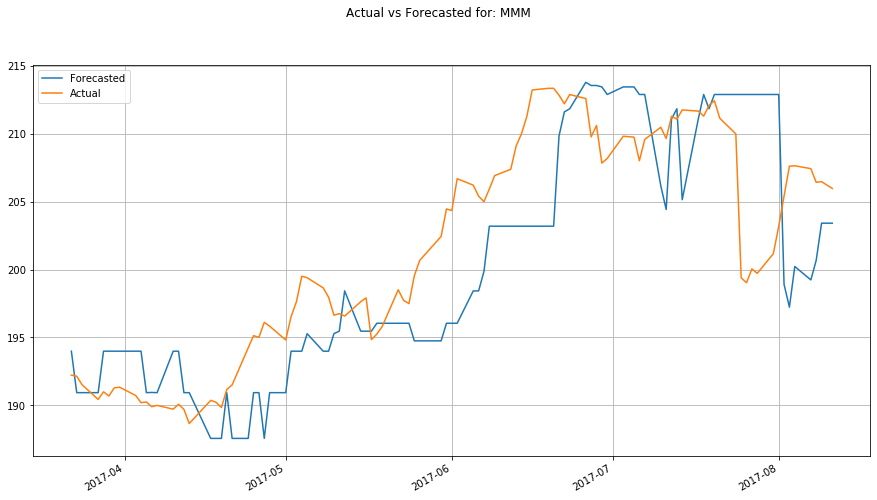

In [43]:
# get accuracy of score 
fig, ax = plt.subplots(figsize=(15,8))
plt.plot(pd.to_datetime(tmp_df['prediction_date']), list(np.exp(preds)), label='Forecasted')
plt.plot(pd.to_datetime(tmp_df['prediction_date']), list(np.exp(tmp_df[LABEL])), label='Actual')

plt.legend()
plt.suptitle('Actual vs Forecasted for: ' + val_stock)
plt.grid()
plt.xticks(rotation='vertical')
ax.xaxis_date()
fig.autofmt_xdate()
plt.show()

In [44]:
#compare the real y values results to the models prediction

#mean squared error between real y values and models predictions

from sklearn.metrics import mean_squared_error

score=mean_squared_error(np.exp(tmp_df[LABEL]), np.exp(preds), squared=False)
# score=1-score/np.mean(tmp_df[LABEL])
print('Mean squared error: '+str(score))

Mean squared error: 5.477797464505127


In [45]:
stats_actual=pd.DataFrame(tmp_df[LABEL].describe())
stats_actual

,outcome
count,100.000000
mean,5.304872
std,0.039635
min,5.239893
25%,5.272794
50%,5.300115
75%,5.343434
max,5.362981


In [46]:
pred=pd.DataFrame(list(preds))
stats_pred=pred.describe()
stats_pred

,0
count,100.000000
mean,5.298557
std,0.042396
min,5.234074
25%,5.267772
50%,5.281353
75%,5.347833
max,5.365051


- As we can see the model is not terrible at forecasting the trend however it is not ideal for trading it. Even though the mean squared error is less that 5 dollars, there are a few problems such as the forecasted trend seems to be lag a little and is more volatile.

# Testing model on live data

- We will be using live data pulled in from yahoo using pandas_datareader

In [47]:
import datetime 
import pandas_datareader as dt

symbol='MSFT'

#last 60 days
start=datetime.datetime.now()
end=datetime.datetime.now()-datetime.timedelta(days=65)

live_stock_data=dt.DataReader(symbol, 'yahoo', end, start)
live_stock_data.reset_index(inplace=True)

live_stock_data.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
41,2020-07-01,206.350006,201.770004,203.139999,204.699997,32061200.0,204.699997
42,2020-07-02,208.020004,205.000000,205.679993,206.259995,29315800.0,206.259995
43,2020-07-06,211.130005,208.089996,208.830002,210.699997,31897600.0,210.699997
44,2020-07-07,214.669998,207.990005,210.449997,208.250000,33530900.0,208.250000
45,2020-07-08,212.669998,209.580002,210.070007,210.595001,7654059.0,210.595001


- We have to get this dataset into the same format we did earlier(stock_model_ready df), so we can pas it to the model and forecast the live data.

- We will need to apply log transforms as the model has been trained in log format aswell

In [48]:
# prepare the live data for forecasting - log tranform it 
live_stock_data = live_stock_data[[ 'Date', 'Close']]

# make data model ready

#log transform it
live_stock_data['Close'] = np.log(live_stock_data['Close'])

# sort by ascending dates as we've done in training 
live_stock_data = live_stock_data.sort_values('Date')
live_stock_data.head()

,Date,Close
0,2020-05-04,5.186492
1,2020-05-05,5.197170
2,2020-05-06,5.206969
3,2020-05-07,5.212760
4,2020-05-08,5.218625


In [49]:
#building the dataset as we did before 
X = []
y = []
prediction_dates = []
last_market_dates = []

rolling_period=10
predict_out_period=5

for per in range(rolling_period,len(live_stock_data)):
    X_tmp=[]
    for rollper in range(per-rolling_period,per):
        #populate the values in X_tmp
        X_tmp+=[live_stock_data['Close'].values[rollper]]
    
    X.append(np.array(X_tmp))
    
    #append the last market dates and prediction dates
    prediction_dates.append(live_stock_data['Date'].values[per] + 
                             np.timedelta64(predict_out_period,'D'))
    
    last_market_dates.append(live_stock_data['Date'].values[per])
    

live_stock_ready_df = pd.DataFrame(X)



live_stock_ready_df['prediction_date'] = prediction_dates
live_stock_ready_df['last_market_date'] = last_market_dates



In [50]:
live_stock_ready_df.tail()

,0,1,2,3,4,5,6,7,8,9,prediction_date,last_market_date
31,5.269095,5.279746,5.273768,5.301163,5.307822,5.287459,5.300016,5.279797,5.290487,5.315715,2020-07-06,2020-07-01
32,5.279746,5.273768,5.301163,5.307822,5.287459,5.300016,5.279797,5.290487,5.315715,5.321545,2020-07-07,2020-07-02
33,5.273768,5.301163,5.307822,5.287459,5.300016,5.279797,5.290487,5.315715,5.321545,5.329137,2020-07-11,2020-07-06
34,5.301163,5.307822,5.287459,5.300016,5.279797,5.290487,5.315715,5.321545,5.329137,5.350435,2020-07-12,2020-07-07
35,5.307822,5.287459,5.300016,5.279797,5.290487,5.315715,5.321545,5.329137,5.350435,5.338739,2020-07-13,2020-07-08


In [51]:
# create time-series feature engineering

#Seperate the features out 
stock_feat = xgb.DMatrix(data = live_stock_ready_df[FEATURES])
# predictions
live_preds = stock_model.predict(stock_feat)

#get the last 10 values for the model prediction
live_preds[(len(live_preds)-10):len(live_preds)]


array([5.296715 , 5.274409 , 5.2895684, 5.2753515, 5.2753515, 5.3141785,
       5.3141785, 5.3141785, 5.346321 , 5.3196816], dtype=float32)

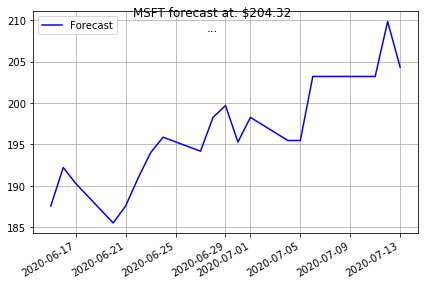

In [52]:
future_df_tmp = live_stock_ready_df.copy()
future_df_tmp['forecast'] = np.exp(list(live_preds))
# just need a couple of rows
future_df_tmp = future_df_tmp.tail(20)

future_df_tmp = future_df_tmp.sort_values('prediction_date')
fig, axes = plt.subplots()
plt.suptitle(symbol + ' forecast at: $'+ str(np.round(future_df_tmp['forecast'].values[-1],2)) + '\n' + '...')
plt.plot(pd.to_datetime(future_df_tmp['prediction_date'].astype(str)), future_df_tmp['forecast'], color='blue', label='Forecast')

#plt.plot(pd.to_datetime(live_stock_data['Date'].astype(str)), np.exp(live_stock_data['Close']), color='green', label='Real')

plt.legend()
plt.grid()
plt.xticks(rotation='vertical')
ax.xaxis_date()
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

In [53]:
future_df_tmp['forecast'].values[-1]

204.31883

In [54]:
future_df_tmp.tail(1).values[0][0:predict_out_period-1]

array([5.307822071699618, 5.2874586047027, 5.300015904904146,
       5.27979692623707], dtype=object)

In [55]:
future_df_tmp

,0,1,2,3,4,5,6,7,8,9,prediction_date,last_market_date,forecast
16,5.202962,5.200705,5.210851,5.208557,5.219869,5.222300,5.209049,5.232178,5.238355,5.245971,2020-06-15,2020-06-10,187.555374
17,5.200705,5.210851,5.208557,5.219869,5.222300,5.209049,5.232178,5.238355,5.245971,5.282391,2020-06-16,2020-06-11,192.198044
18,5.210851,5.208557,5.219869,5.222300,5.209049,5.232178,5.238355,5.245971,5.282391,5.227197,2020-06-17,2020-06-12,190.266724
19,5.208557,5.219869,5.222300,5.209049,5.232178,5.238355,5.245971,5.282391,5.227197,5.235058,2020-06-20,2020-06-15,185.502121
20,5.219869,5.222300,5.209049,5.232178,5.238355,5.245971,5.282391,5.227197,5.235058,5.241430,2020-06-21,2020-06-16,187.555374
21,5.222300,5.209049,5.232178,5.238355,5.245971,5.282391,5.227197,5.235058,5.241430,5.265639,2020-06-22,2020-06-17,190.926727
22,5.209049,5.232178,5.238355,5.245971,5.282391,5.227197,5.235058,5.241430,5.265639,5.269095,2020-06-23,2020-06-18,193.983322
23,5.232178,5.238355,5.245971,5.282391,5.227197,5.235058,5.241430,5.265639,5.269095,5.279746,2020-06-24,2020-06-19,195.857361
24,5.238355,5.245971,5.282391,5.227197,5.235058,5.241430,5.265639,5.269095,5.279746,5.273768,2020-06-27,2020-06-22,194.166275
25,5.245971,5.282391,5.227197,5.235058,5.241430,5.265639,5.269095,5.279746,5.273768,5.301163,2020-06-28,2020-06-23,198.241211


([<matplotlib.axis.XTick at 0x3c119b00>,
 <a list of 14 Text xticklabel objects>)

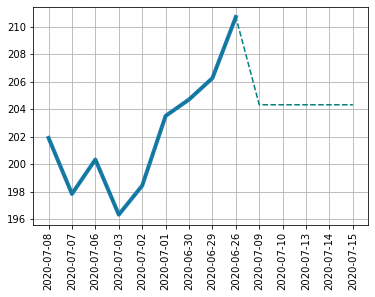

In [56]:
#actuals are the historical stock market values
# in this example we are taking the last 9 historical values
actuals = list(future_df_tmp.tail(1).values[0])[0:rolling_period-1]
# # transform log price to price of past data
actuals = list(np.exp(actuals))



#taking the last market date (today)
days_before = future_df_tmp['last_market_date'].values[-1]
#The following loop will iterate (0-9) and append the 9 previous dates 
#before last market date 
days_before_list = []
for d in range(rolling_period-1):
    days_before_list.append(str(np.busday_offset(np.datetime64(days_before,'D'),-d, roll='backward')))

#plot the historical market values (previous 9 days)
plt.plot(days_before_list, actuals, linewidth=4)


#Similarly the following loop will iterate(1-5) and append the upcoming 5 
#days dates to days_before_list as a continuation; also it will add the 5 
#days out prediction to actuals
for d in range(1, predict_out_period+1):
    days_before_list.append(str(np.busday_offset(np.datetime64(days_before,'D'),d, roll='forward')))
    actuals.append(future_df_tmp['forecast'].values[-1])
     
#plot 
#plt.suptitle('Forcast for ' + str(future_df_tmp['Date'].values[-1])[0:10] + ': $' + str(np.round(future_df_tmp['forecast'].values[-1],2)))
plt.plot(days_before_list, actuals, color='teal',linestyle='dashed', linewidth=1.5)
plt.grid()
plt.xticks(days_before_list, days_before_list, rotation='vertical')


# Displaying findings on the web 


### Rest API's

- The goal is to pass any stock symbol and to receive the 5 day forecast. We can do this through using a rest api.

- A Rest API is very simple way to get functions running on the web. These functions rest on the web until someone calls them.


- A rest api uses commands such as get, post, delete, update... and passes the data on top the HTTP protocol. This allows us to use the tech that is mainly used for rendering webpages to carry out calculations.

- We can use Rest APIs to make advanced predictive analytics and even run machine learning algorithms.

- One way to simply run these predictive analytics is by using class function. We can place the function which gets the 5 days stock forecast within the class function and add it to the API resource; every time we call that function and pass a specific query from the web, we will receive the output value of that function dynamically.




### Using HTML to report forecasts visually


-  We can display the final chart displayed on this notebook dynamycally on html. We would have to put all the code we used on this notebook into simple function save it as a python file. 


- Using flaskapp we can tie the html file and python file together and display the findings live dynamically upon request


